In [61]:
using Interpolations
using ProfileView
using ForwardDiff
using PyPlot
using FixedSizeArrays

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
include("Acrobots/src/Acrobots.jl")

Acrobots

In [7]:
function unwrap{State}(state::State)
    if state.theta1 < 0
        state = State(state.theta1 + 2*pi, state.theta2, state.theta1dot, state.theta2dot)
    end
    if state.theta1 > 2*pi
        state = State(state.theta1 - 2*pi, state.theta2, state.theta1dot, state.theta2dot)
    end
    state
end
    

unwrap (generic function with 1 method)

In [112]:
xdes = Acrobots.AcrobotState{Float64}(pi, 0, 0, 0)
x0 = Acrobots.AcrobotState{Float64}([0.2*(rand(2)-0.5); zeros(2)]) + Acrobots.AcrobotState(0, 0, 0, 0)
state = x0
robot = Acrobots.acrobot()
input = Acrobots.AcrobotInput{Float64}(0)
dt = 0.001
vis = Acrobots.DrakeVisualizer(robot)
ts = 0:dt:5
Qf = diagm([100,100,1,1])
Rf = eye(1)

function cost(state::Acrobots.AcrobotState)
#     if state.theta1 > 0
#         x = convert(Vector, state - xdes)
#     else
#         x = convert(Vector, state - Acrobots.AcrobotState{Float64}(-pi, 0, 0, 0))
#     end
#     return 0.5*(x' * Qf * x)[1]
    y = cos(state.theta1) + 2*cos(state.theta2 + state.theta1)
    return 10*y + state.theta1dot^2 + state.theta2dot^2 
end
Q_generator = ForwardDiff.hessian(x -> cost(Acrobots.AcrobotState(x)), ForwardDiff.AllResults)

function cost(input::Acrobots.AcrobotInput)
    return input.tau^2
end
R_generator = ForwardDiff.hessian(x -> cost(Acrobots.AcrobotInput(x)), ForwardDiff.AllResults)

sys_tf = Acrobots.linearize(robot, 0, xdes, input)
P_tf = Mat(Acrobots.care(convert(Matrix, sys_tf.A), convert(Matrix, sys_tf.B), Qf, Rf))
p_tf = -P_tf * xdes

Qs = Mat{4, 4, Float64}[]
Rs = Mat{1, 1, Float64}[]
qs = Vec{4, Float64}[]
rs = Vec{1, Float64}[]
Ps = Mat{4, 4, Float64}[]
ps = Vec{4, Float64}[]

controller_state = Acrobots.LQRState{Float64}(())
linear_sys = Acrobots.linearize(robot, 0, x0, input)
controller = Acrobots.lqr(linear_sys, Qf, Rf, x0)
linearizations = typeof(linear_sys)[]

Profile.clear()
elapsed = @elapsed for (i, t) in enumerate(ts)
    output = Acrobots.output(robot, t, state, input)
    input = Acrobots.output(controller, t, controller_state, output)
    statedot = Acrobots.dynamics(robot, t, state, input)
    state += statedot * dt
#     state = unwrap(state)
    push!(linearizations, Acrobots.linearize(robot, t, state, input))
    
    Q, Q_results = Q_generator(convert(Vector, state))
    push!(Qs, Q)
    push!(qs, ForwardDiff.gradient(Q_results))
    R, R_results = R_generator(convert(Vector, input))
    push!(Rs, R)
    push!(rs, ForwardDiff.gradient(R_results))
#     push!(Qs, Mat{4, 4, Float64}(diagm([10, 10, 1, 1])))
#     push!(qs, -Qs[end] * Vec(pi, 0, 0, 0))
#     push!(Rs, Mat{1, 1, Float64}(1))
#     push!(rs, Vec(0.0))
    
#     if mod(i, 10) == 0
        Acrobots.draw(vis, state)
#     end
end
@show elapsed / length(ts) * 1e6
# ProfileView.view()

(elapsed / length(ts)) * 1.0e6 = 648.7742293541291

648.7742293541291

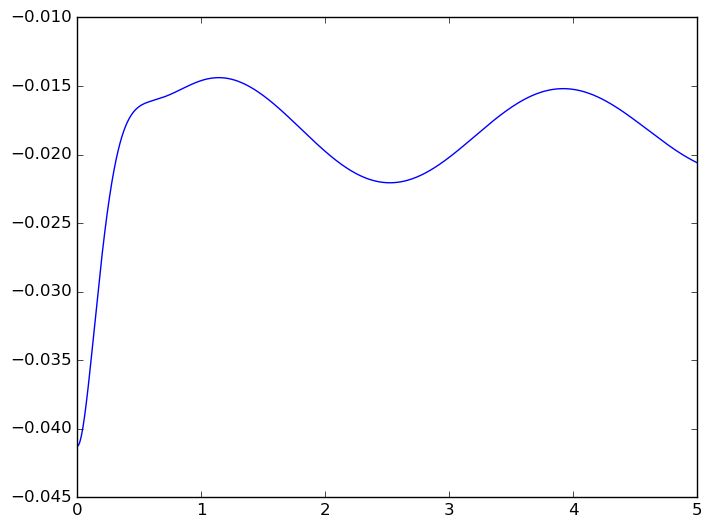

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa7fc8b2dd0>

In [113]:
plot(ts, [lin.x0[1] for lin in linearizations])

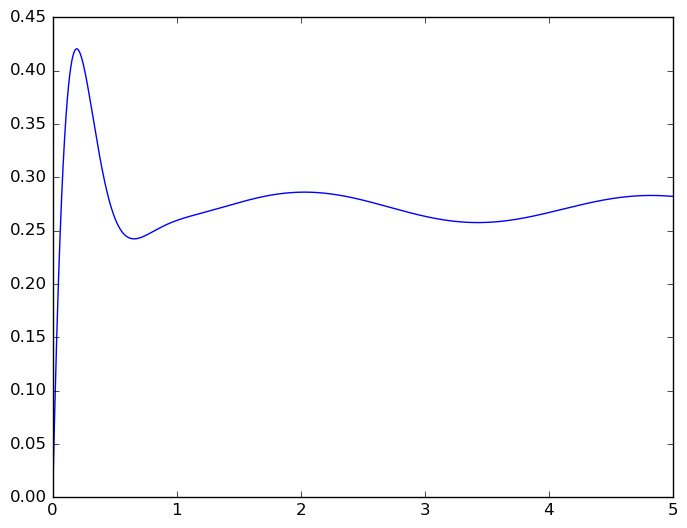

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa7fc7ef490>

In [114]:
plot(ts, [lin.u0[1] for lin in linearizations])

In [115]:
alpha = 0.5

for i = 1:10

    Ps = Array{Mat{4, 4, Float64}}(length(ts))
    ps = Array{Vec{4, Float64}}(length(ts))
    Ks = Array{Mat{1, 4, Float64}}(length(ts))
    ls = Array{Vec{1, Float64}}(length(ts))
    As = [dt * sys.A for sys in linearizations]
    Bs = [dt * sys.B for sys in linearizations]

    Ps[end] = P_tf
    ps[end] = p_tf

    for j = (length(ts)-1):-1:1
        g = rs[j] + Bs[j]' * ps[j+1]
        G = Bs[j]' * Ps[j+1] * As[j]
        H = Rs[j] + Bs[j]' * Ps[j+1] * Bs[j]
        Hi = inv(H)
        Ks[j] = -Hi * G
        ls[j] = -Hi * g

        M = inv(Mat{4,4,Float64}(eye(4)) + Bs[j] * inv(Rs[j]) * Bs[j]' * Ps[j+1])
        ps[j] = (As[j]' * (Mat{4,4,Float64}(eye(4)) - Ps[j+1] * M * Bs[j] * inv(Rs[j]) * Bs[j]') * ps[j+1] 
            + As[j]' * Ps[j+1] * M * Bs[j] * linearizations[j].u0 + qs[j])

    #     ps[j] = qs[j] + As[j]' * ps[j+1] + Ks[j]' * H * ls[j] + G' * ls[j] # TODO: can neunertm help?
        Ps[j] = Qs[j] + As[j]' * Ps[j+1] * As[j] + Ks[j]' * H * Ks[j] + Ks[j]' * G + G' * Ks[j]
    end
    Ks[end] = Ks[end-1]
    ls[end] = ls[end-1]

    controllers = [Acrobots.AffineSystem(
        Mat{0,0,Float64}(),
        Mat{0,4,Float64}(),
        Mat{1,0,Float64}(),
        Mat{1,4,Float64}(Ks[j]),
        Acrobots.LQRState{Float64}(),
        Acrobots.AcrobotOutput{Float64}(linearizations[j].x0),
        Acrobots.LQRState{Float64}(),
        Acrobots.AcrobotInput{Float64}(linearizations[j].u0) + Acrobots.AcrobotInput{Float64}(alpha * ls[j])) 
        for j in 1:length(ts)]


    state = x0
    input = Acrobots.AcrobotInput{Float64}(0)
    empty!(linearizations)
    empty!(Qs)
    empty!(Rs)
    empty!(qs)
    empty!(rs)

    elapsed = @elapsed for (i, t) in enumerate(ts)
        output = Acrobots.output(robot, t, state, input)
        input = Acrobots.output(controllers[i], t, controller_state, output)
        statedot = Acrobots.dynamics(robot, t, state, input)
        state += statedot * dt
        state = unwrap(state)
        push!(linearizations, Acrobots.linearize(robot, t, state, input))

        Q, Q_results = Q_generator(convert(Vector, state))
        push!(Qs, Q)
        push!(qs, ForwardDiff.gradient(Q_results))
        R, R_results = R_generator(convert(Vector, input))
        push!(Rs, R)
        push!(rs, ForwardDiff.gradient(R_results))

        if mod(i, 10) == 0
            Acrobots.draw(vis, state)
        end
    end
    
end

In [79]:
Qs[1]

FixedSizeArrays.Mat{4,4,Float64}(
    -29.926638646305598 -19.94969491701665 0.0 0.0
    -19.94969491701665 -19.94969491701665 0.0 0.0
    0.0 0.0 2.0 0.0
    0.0 0.0 0.0 2.0
)


In [77]:
cost(linearizations[end].x0)

30.014575367522283

In [5]:
alpha = 0.1
for i = 1:10
    lin = interpolate((ts,), linearizations, Gridded(Linear()));

    Qs_interp = interpolate((ts,), Qs, Gridded(Linear()))
    Rs_interp = interpolate((ts,), Rs, Gridded(Linear()))
    controllers = Acrobots.tvlqr(lin, Acrobots.AcrobotState{Float64}(pi,0,0,0), Qs_interp, Rs_interp, diagm([10.,10,1,1]), eye(1));
    
    for j = 1:size(controllers.coefs, 1)
        controllers.coefs[j] = typeof(controllers.coefs[j])(
            controllers.coefs[j].A,
            controllers.coefs[j].B,
            controllers.coefs[j].C,
            controllers.coefs[j].D,
            controllers.coefs[j].x0,
            controllers.coefs[j].u0,
            controllers.coefs[j].xd0,
            controllers.coefs[j].y0 * alpha + lin.coefs[j].u0 * (1 - alpha),
        )
    end
        
    state = x0
    input = Acrobots.AcrobotInput{Float64}(0)
    empty!(linearizations)
    empty!(Qs)
    empty!(Rs)

    elapsed = @elapsed for (i, t) in enumerate(ts)
        output = Acrobots.output(robot, t, state, input)
        input = Acrobots.output(controllers[t], t, controller_state, output)
        input = min(max(input, -5), 5)
        statedot = Acrobots.dynamics(robot, t, state, input)
        state += statedot * dt
        state = unwrap(state)
        push!(linearizations, Acrobots.linearize(robot, t, state, input))

        Q = Q_generator(convert(Vector, state))
        R = R_generator(convert(Vector, input))
        push!(Qs, Q)
        push!(Rs, R)

#         if mod(i, 10) == 0
            Acrobots.draw(vis, state)
#         end
    end
end

LoadError: LoadError: UndefVarError: linearizations not defined
while loading In[5], in expression starting on line 2

In [6]:
robot = Acrobots.acrobot()
state = Acrobots.AcrobotState{Float64}([1.; 2.;3.; 4.])
input = Acrobots.AcrobotInput{Float64}(5.)
statedot = Acrobots.dynamics(robot, 0, state, input)
expected = Acrobots.AcrobotState{Float64}(3.0000, 4.0000, 21.3827, -18.4276)
@assert isapprox(statedot, expected, 1e-4)

linear_sys = Acrobots.linearize(robot, 0, state, input)
@assert isapprox(statedot, Acrobots.dynamics(linear_sys, 0, state, input), 1e-9)

vis = Acrobots.DrakeVisualizer(robot)
state = Acrobots.AcrobotState{Float64}([pi/4;pi/4;0;0])
Acrobots.draw(vis, state)